In [11]:
import numpy as np
import pandas as pd
import cv2
import os
import glob
import matplotlib.pyplot as plt
import pickle
import sys


np.set_printoptions(threshold=sys.maxsize)

%matplotlib inline

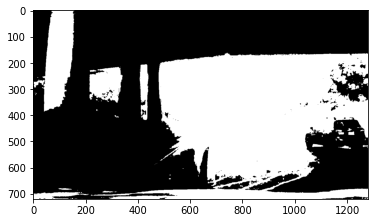

In [46]:
def binn(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #(thresh, im_bw) = cv2.threshold(gray, 255, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    gray = cv2.equalizeHist(gray)
    #print(gray)
    # closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

    im_bw = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)[1]

    plt.imshow(im_bw , cmap ="gray")


img = cv2.imread("test_images/one.png")
binn(img)

In [ ]:
def undistort_img():
    # Prepare object points 0,0,0 ... 8,5,0
    obj_pts = np.zeros((6*9,3), np.float32)
    obj_pts[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Stores all object points & img points from all images
    objpoints = []
    imgpoints = []

    # Get directory for all calibration images
    images = glob.glob('camera_cal/*.jpg')

    for indx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if ret == True:
            objpoints.append(obj_pts)
            imgpoints.append(corners)
    # Test undistortion on img
    img_size = (img.shape[1], img.shape[0])

    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    # Save camera calibration for later use
    dist_pickle = {}
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist
    pickle.dump( dist_pickle, open('camera_cal/cal_pickle.p', 'wb') )

def undistort(img, cal_dir='camera_cal/cal_pickle.p'):
    #cv2.imwrite('camera_cal/test_cal.jpg', dst)
    with open(cal_dir, mode='rb') as f:
        file = pickle.load(f)
    mtx = file['mtx']
    dist = file['dist']
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return dst

In [ ]:
def abs_sobel_thresh(gray, orient='x', thresh=(0, 255)):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    sobel_mask = binary_output
    # Return the result
    return sobel_mask

In [ ]:
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    dir_mask = binary_output
    # Return the binary image
    return dir_mask

In [ ]:
def combine_thresh(img, s_thresh=(100, 255), l_thresh=(120, 255)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    height, width = gray.shape
    
    #combined = ((grad_x == 1)  & (grad_y == 1) & (mag_binary == 1) & (dir_binary == 1))
    grad_x = abs_sobel_thresh(gray, 'x', thresh=(10, 200))
    dir_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    combined = ((grad_x == 1) & (dir_binary == 1))
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    # Apply color threshold for better detection of yello and white lines in all environmental condition
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Select S channel because it is usually the best performant
    # for this task. R channel also performs similarly.
    s_channel = hls[:,:,2] 
    l_channel = hls[:,:,1]
    
     # S channel performs well for detecting bright yellow and white lanes
    s_condition = (s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])
    
    # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.   
    l_condition = (l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])
    
    # combine all the thresholds
    # A pixel should either be a yellowish or whiteish
    # And it should also have a gradient, as per our thresholds
    color_combined[(r_g_condition & l_condition) & (s_condition | combined)] = 1
    
    #binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    # apply the region of interest mask
    mask = np.zeros_like(color_combined)
#     np.array([[int(0), int(y)], [int(x), int(y)], [int(0.55*x), int(0.6*y)], [int(0.45*x), int(0.6*y)]]
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.55*height)], [width-1, height-1]], dtype=np.int32)
    region_of_disinterest_vertices = np.array([[0.40*width,height-1], [width/2, int(0.55*height)], [width-1-0.40*width, height-1]], dtype=np.int32)
#moraba3#    region_of_interest_vertices = np.array([[0,height-1],[width-1, height-1], [int(0.55*width), int(0.6*height)],[int(0.45*width), int(0.6*height)] ], dtype=np.int32)
#     region_of_interest_vertices = np.array([[150,height-1],[1200, height-1], [int(0.55*width), int(0.7*height)],[int(0.45*width), int(0.7*height)] ], dtype=np.int32)

    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    cv2.fillPoly(mask, [region_of_disinterest_vertices], 0)

    thresholded = cv2.bitwise_and(color_combined, mask)

    return thresholded

In [ ]:
def thresholding(img):

    thresholded = combine_thresh(img,s_thresh=(100, 255), l_thresh=(120, 255))
    return thresholded

In [ ]:
def perspective_warp(img, 
                     dst_size=(1280,720),
                     src=np.float32([(0.43,0.65),(0.58,0.65),(0.1,1),(1,1)]),
                     dst=np.float32([(0,0), (1, 0), (0,1), (1,1)])):
    img_size = np.float32([(img.shape[1],img.shape[0])])
    src = src* img_size
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = dst * np.float32(dst_size)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    M_Inv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, dst_size)
    return warped

In [ ]:
def inv_perspective_warp(img, 
                     dst_size=(1280,720),
                     src=np.float32([(0,0), (1, 0), (0,1), (1,1)]),
                     dst=np.float32([(0.43,0.65),(0.58,0.65),(0.1,1),(1,1)])):
    img_size = np.float32([(img.shape[1],img.shape[0])])
    src = src* img_size
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = dst * np.float32(dst_size)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, dst_size)
    return warped

In [ ]:
def get_hist(img):
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    return hist

In [ ]:
left_a, left_b, left_c = [],[],[]
right_a, right_b, right_c = [],[],[]

def sliding_window(img, nwindows=9, margin=150, minpix = 1, draw_windows=True):
    global left_a, left_b, left_c,right_a, right_b, right_c
    left_fit_= np.empty(3)
    right_fit_ = np.empty(3)
    
    out_img = np.dstack((img, img, img))*255

    histogram = get_hist(img)
    # find peaks of left and right halves
    midpoint = int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if draw_windows == True:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (100,255,255), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (100,255,255), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds)  > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds)  > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    if(lefty.size != 0 and leftx.size != 0):
        left_fit = np.polyfit(lefty, leftx, 2)

        left_a.append(left_fit[0])
        left_b.append(left_fit[1])
        left_c.append(left_fit[2])

    else:
        left_a.append(left_a[-1])
        left_b.append(left_b[-1])
        left_c.append(left_c[-1])

    if(righty.size !=0 and rightx.size !=0):
        right_fit = np.polyfit(righty, rightx, 2)
        
        right_a.append(right_fit[0])
        right_b.append(right_fit[1])
        right_c.append(right_fit[2])
    else:
        right_a.append(right_a[-1])
        right_b.append(right_b[-1])
        right_c.append(right_c[-1])
        
    
    left_fit_[0] = np.mean(left_a[-10:])
    left_fit_[1] = np.mean(left_b[-10:])
    left_fit_[2] = np.mean(left_c[-10:])
    
    right_fit_[0] = np.mean(right_a[-10:])
    right_fit_[1] = np.mean(right_b[-10:])
    right_fit_[2] = np.mean(right_c[-10:])
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit_[0]*ploty**2 + left_fit_[1]*ploty + left_fit_[2]
    right_fitx = right_fit_[0]*ploty**2 + right_fit_[1]*ploty + right_fit_[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 100]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 100, 255]
    
    return out_img, (left_fitx, right_fitx), (left_fit_, right_fit_), ploty

In [ ]:
def get_curve(img, leftx, rightx):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    y_eval = np.max(ploty)
    ym_per_pix = 30.5/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/720 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature 
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    car_pos = img.shape[1]/2
    
    l_fit_x_int = left_fit_cr[0]*img.shape[0]**2 + left_fit_cr[1]*img.shape[0] + left_fit_cr[2]
    r_fit_x_int = right_fit_cr[0]*img.shape[0]**2 + right_fit_cr[1]*img.shape[0] + right_fit_cr[2]
    
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center = (car_pos - lane_center_position) * xm_per_pix / 10
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad, center)

In [ ]:
def draw_lanes(img, left_fit, right_fit):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    color_img = np.zeros_like(img)
    
    left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    points = np.hstack((left, right))
    
    cv2.fillPoly(color_img, np.int_(points), (0,200,255))
    inv_perspective = inv_perspective_warp(color_img)
    inv_perspective = cv2.addWeighted(img, 1, inv_perspective, 0.7, 0)
    return inv_perspective


In [ ]:
def full_pipeline(img):
#     undist_img = undistort(img)
    undist_img = img
    th_img = thresholding(undist_img)

    pew_img = perspective_warp(th_img)

    sw_img, curves, lanes, ploty = sliding_window(pew_img, draw_windows=True)

    curverad =get_curve(img, curves[0], curves[1])
    lane_curve = np.mean([curverad[0], curverad[1]])
    img = draw_lanes(img, curves[0], curves[1])
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (0, 0, 0)
    fontSize=0.5
    cv2.putText(img, 'Lane Curvature: {:.0f} m'.format(lane_curve), (570, 620), font, fontSize, fontColor, 2)
    cv2.putText(img, 'Vehicle offset: {:.4f} m'.format(curverad[2]), (570, 650), font, fontSize, fontColor, 2)
    
    th_img_rgb = np.dstack((th_img,th_img,th_img))*255
    
    pew_img_rgb = np.dstack((pew_img,pew_img,pew_img))*255
    
    
    
    img_row1 = np.concatenate((th_img_rgb, pew_img_rgb),axis = 0)

    
    img_row2 = np.concatenate((sw_img, img),axis = 0)

    
    final_img = np.concatenate((img_row1, img_row2),axis = 1)
    final_img = cv2.resize(final_img,(img.shape[1],img.shape[0]))
    
    return final_img

In [ ]:
# img=cv2.imread("test_images/straight_lines1.jpg")
# left_a=[]
# left_b=[]
# left_c=[]
# right_a=[]
# right_b=[]
# right_c=[]
# img = full_pipeline(img)

In [ ]:
right_curves, left_curves = [],[]
from moviepy.editor import VideoFileClip, clips_array

myclip = VideoFileClip('./input/challenge_video.mp4').subclip(0,10)
output_vid = './output/challenge_output_1.mp4'
clip = myclip.fl_image(full_pipeline)

clip.write_videofile(output_vid, audio=False)